## 📌 Narrative Nexus:

### 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import joblib

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
from textblob import TextBlob
from sklearn.cluster import KMeans

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

print("✅ Libraries Imported")

✅ Libraries Imported


### 2. Load & Merge Datasets (BBC, CNN, IMDB)

In [3]:
bbc_path = "../data/bbc-text.csv"
cnn_path = "../data/cnn_dailymail.csv"
imdb_path = "../data/imdb-dataset.csv"

# BBC
bbc_df = pd.read_csv(bbc_path)
bbc_df = bbc_df.rename(columns={"text": "text"})
bbc_df["source"] = "bbc"

# CNN
cnn_df = pd.read_csv(cnn_path)
cnn_df = cnn_df.rename(columns={"article": "text"})
cnn_df["source"] = "cnn"
cnn_df = cnn_df.drop(columns=["summary"])  

# IMDB
imdb_df = pd.read_csv(imdb_path)
imdb_df = imdb_df.rename(columns={"review": "text"})
imdb_df["source"] = "imdb"
imdb_df = imdb_df.drop(columns=["sentiment"])  

# Merge
merged_df = pd.concat([bbc_df, cnn_df, imdb_df], ignore_index=True)
print("📊 Merged Dataset Shape:", merged_df.shape)

📊 Merged Dataset Shape: (57225, 3)


### 3. Data Preprocessing with Tokenization

In [4]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove special chars
    tokens = word_tokenize(text)  # explicit tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

merged_df["clean_text"] = merged_df["text"].dropna().astype(str).apply(preprocess_text)

print("✅ Preprocessing Completed")

# Save preprocessed dataset
merged_df.to_csv("merged_preprocessed.csv", index=False)
print("💾 Preprocessed dataset saved as merged_preprocessed.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\panji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\panji\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\panji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Preprocessing Completed
💾 Preprocessed dataset saved as merged_preprocessed.csv
💾 Preprocessed dataset saved as merged_preprocessed.csv


### 4. Topic Modeling (LDA & NMF) with Evaluation

In [5]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import os

# Prepare data for coherence calculation
tokenized_texts = [doc.split() for doc in merged_df["clean_text"]]
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Vectorization
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
count_matrix = count_vectorizer.fit_transform(merged_df["clean_text"])

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df["clean_text"])

# Train LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(count_matrix)

print("\n📌 LDA Topics:")
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}: ", [count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

# Evaluate LDA
lda_perplexity = lda.perplexity(count_matrix)
print(f"\n📊 LDA Perplexity: {lda_perplexity:.4f}")

# Convert LDA to gensim format for coherence
from gensim.models.ldamodel import LdaModel
gensim_lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=5,
    iterations=50
)
lda_coherence_model = CoherenceModel(model=gensim_lda, texts=tokenized_texts, dictionary=dictionary, coherence="c_v")
lda_coherence = lda_coherence_model.get_coherence()
print(f"📊 LDA Coherence Score: {lda_coherence:.4f}")

# Train NMF
nmf = NMF(n_components=5, random_state=42)
nmf.fit(tfidf_matrix)

print("\n📌 NMF Topics:")
for idx, topic in enumerate(nmf.components_):
    print(f"Topic {idx+1}: ", [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

# Evaluate NMF coherence
# Convert NMF topics into gensim format
nmf_topics = []
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic in nmf.components_:
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    nmf_topics.append(top_words)

nmf_coherence_model = CoherenceModel(topics=nmf_topics, texts=tokenized_texts, dictionary=dictionary, coherence="c_v")
nmf_coherence = nmf_coherence_model.get_coherence()
print(f"\n📊 NMF Coherence Score: {nmf_coherence:.4f}")

# Create model directory if it doesn't exist
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"📁 Created directory: {model_dir}")

# Save trained models with proper paths
import joblib
joblib.dump(lda, f"{model_dir}/lda_model.pkl")
joblib.dump(nmf, f"{model_dir}/nmf_model.pkl")
joblib.dump(count_vectorizer, f"{model_dir}/count_vectorizer.pkl")
joblib.dump(tfidf_vectorizer, f"{model_dir}/tfidf_vectorizer.pkl")

print("💾 Models saved successfully:")
print(f"   - {model_dir}/lda_model.pkl")
print(f"   - {model_dir}/nmf_model.pkl") 
print(f"   - {model_dir}/count_vectorizer.pkl")
print(f"   - {model_dir}/tfidf_vectorizer.pkl")


📌 LDA Topics:
Topic 1:  ['life', 'play', 'great', 'song', 'like', 'new', 'music', 'best', 'time', 'year']
Topic 1:  ['life', 'play', 'great', 'song', 'like', 'new', 'music', 'best', 'time', 'year']
Topic 2:  ['president', 'told', 'government', 'new', 'say', 'state', 'cnn', 'year', 'people', 'said']
Topic 2:  ['president', 'told', 'government', 'new', 'say', 'state', 'cnn', 'year', 'people', 'said']
Topic 3:  ['great', 'good', 'time', 'story', 'like', 'movie', 'scene', 'character', 'br', 'film']
Topic 3:  ['great', 'good', 'time', 'story', 'like', 'movie', 'scene', 'character', 'br', 'film']
Topic 4:  ['make', 'dont', 'time', 'film', 'really', 'bad', 'good', 'like', 'br', 'movie']
Topic 4:  ['make', 'dont', 'time', 'film', 'really', 'bad', 'good', 'like', 'br', 'movie']
Topic 5:  ['love', 'time', 'people', 'like', 'life', 'character', 'story', 'film', 'movie', 'br']
Topic 5:  ['love', 'time', 'people', 'like', 'life', 'character', 'story', 'film', 'movie', 'br']

📊 LDA Perplexity: 4896

### 5. Sentiment Analysis (Rule-based, ML, DL)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import joblib

#### Step 1: Prepare labeled dataset (IMDB only)

In [7]:
imdb_path = "../data/imdb-dataset.csv"
imdb_df = pd.read_csv(imdb_path)
imdb_df["sentiment"] = imdb_df["sentiment"].map({"positive":1, "negative":0})  # binary labels

X = imdb_df["review"].astype(str)
y = imdb_df["sentiment"]

print("📊 IMDB Dataset for Sentiment:", X.shape, y.shape)

📊 IMDB Dataset for Sentiment: (50000,) (50000,)


##### Helper Function: Evaluate Model

In [8]:
def evaluate_model(y_true, y_pred, y_prob, model_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    neg_recall = recall_score(y_true, y_pred, pos_label=0)

    print(f"\n📌 {model_name} Evaluation:")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-Score:", f1)
    print("ROC-AUC:", roc)
    print("Negative Recall:", neg_recall)

    # Plot confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "roc":roc, "neg_recall":neg_recall}

#### Step 2: Rule-based Sentiment (TextBlob)


📌 Rule-Based (TextBlob) Evaluation:
Accuracy: 0.68828
Precision: 0.6239858813612896
Recall: 0.94756
F1-Score: 0.7524617241598374
ROC-AUC: 0.68828
Negative Recall: 0.429


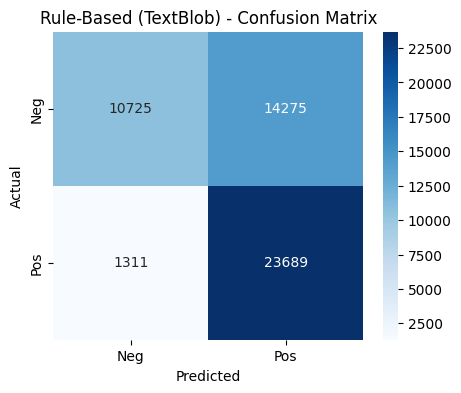


📌 Rule-Based Sentiment Evaluation:
Accuracy: 0.68828
Precision: 0.6239858813612896
Recall: 0.94756
F1-Score: 0.7524617241598374
ROC-AUC: 0.68828
Negative Recall: 0.429


In [9]:
from textblob import TextBlob

def rule_based_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    return 1 if polarity >= 0 else 0

y_pred_rule = X.apply(rule_based_sentiment)
y_prob_rule = y_pred_rule  # rule-based has no prob, treat as hard labels
rule_results = evaluate_model(y, y_pred_rule, y_prob_rule, "Rule-Based (TextBlob)")

print("\n📌 Rule-Based Sentiment Evaluation:")
print("Accuracy:", accuracy_score(y, y_pred_rule))
print("Precision:", precision_score(y, y_pred_rule))
print("Recall:", recall_score(y, y_pred_rule))
print("F1-Score:", f1_score(y, y_pred_rule))
print("ROC-AUC:", roc_auc_score(y, y_pred_rule))
print("Negative Recall:", recall_score(y, y_pred_rule, pos_label=0))

#### Step 3: Machine Learning Sentiment (Logistic Regression)


📌 Machine Learning (LogReg) Evaluation:
Accuracy: 0.8895
Precision: 0.8788520801232665
Recall: 0.9055368128596943
F1-Score: 0.8919949174078781
ROC-AUC: 0.9563054216218514
Negative Recall: 0.8732110461600484


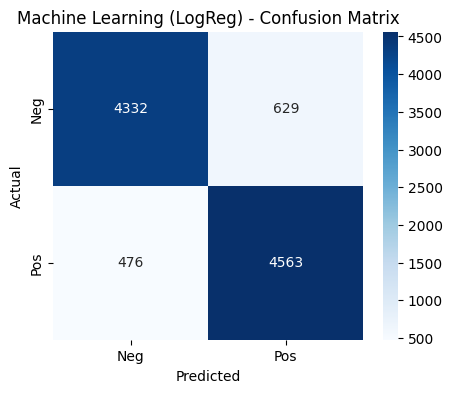


📌 Machine Learning (LogReg) Evaluation:
Accuracy: 0.8895
Precision: 0.8788520801232665
Recall: 0.9055368128596943
F1-Score: 0.8919949174078781
ROC-AUC: 0.9563054216218514
Negative Recall: 0.8732110461600484
💾 ML Sentiment Model Saved
💾 ML Sentiment Model Saved


In [10]:
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

ml_model = LogisticRegression(max_iter=500)
ml_model.fit(X_train, y_train)
y_pred_ml = ml_model.predict(X_test)
y_prob_ml = ml_model.predict_proba(X_test)[:,1]

ml_results = evaluate_model(y_test, y_pred_ml, y_prob_ml, "Machine Learning (LogReg)")

print("\n📌 Machine Learning (LogReg) Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_ml))
print("Precision:", precision_score(y_test, y_pred_ml))
print("Recall:", recall_score(y_test, y_pred_ml))
print("F1-Score:", f1_score(y_test, y_pred_ml))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_ml))
print("Negative Recall:", recall_score(y_test, y_pred_ml, pos_label=0))

# Save ML model
joblib.dump(ml_model, "models/sentiment_ml.pkl")
joblib.dump(tfidf, "models/sentiment_tfidf.pkl")
print("💾 ML Sentiment Model Saved")

#### Step 4: Deep Learning Sentiment (LSTM)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 136ms/step - accuracy: 0.6309 - loss: 0.6332 - val_accuracy: 0.6522 - val_loss: 0.6251
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 136ms/step - accuracy: 0.6309 - loss: 0.6332 - val_accuracy: 0.6522 - val_loss: 0.6251
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - accuracy: 0.7480 - loss: 0.5176 - val_accuracy: 0.6943 - val_loss: 0.5408
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - accuracy: 0.7480 - loss: 0.5176 - val_accuracy: 0.6943 - val_loss: 0.5408
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - accuracy: 0.7937 - loss: 0.4580 - val_accuracy: 0.8507 - val_loss: 0.4044
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - accuracy: 0.7937 - loss: 0.4580 - val_accuracy: 0.8507 - val_loss: 0.4044
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step

📌 Deep Learning (LSTM) Evaluation:
Accuracy: 0.8507
Precision: 0.826278984173721
Recall: 0.8910498114705299
F1-Score: 0.8574429485343263
ROC-AUC:

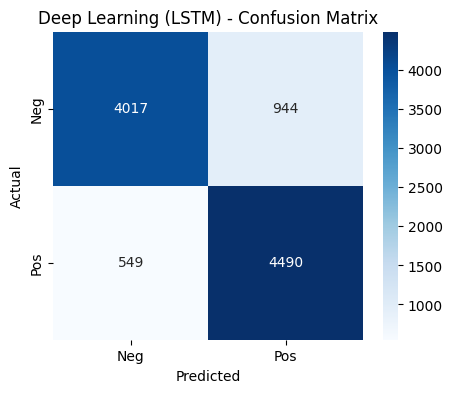


📌 Deep Learning (LSTM) Evaluation:
Accuracy: 0.8507
Precision: 0.826278984173721
Recall: 0.8910498114705299
F1-Score: 0.8574429485343263
ROC-AUC: 0.9002524313579239
Negative Recall: 0.8097157831082443
💾 Deep Learning Sentiment Model Saved
💾 Deep Learning Sentiment Model Saved


In [11]:
max_words = 10000
max_len = 200
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding="post")
y_array = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_array, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_prob_dl = model.predict(X_test).flatten()
y_pred_dl = (y_prob_dl >= 0.5).astype(int)

dl_results = evaluate_model(y_test, y_pred_dl, y_prob_dl, "Deep Learning (LSTM)")

print("\n📌 Deep Learning (LSTM) Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_dl))
print("Precision:", precision_score(y_test, y_pred_dl))
print("Recall:", recall_score(y_test, y_pred_dl))
print("F1-Score:", f1_score(y_test, y_pred_dl))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dl))
print("Negative Recall:", recall_score(y_test, y_pred_dl, pos_label=0))

# Save DL model + tokenizer
model.save("models/sentiment_lstm.h5")
joblib.dump(tokenizer, "models/sentiment_tokenizer.pkl")
print("💾 Deep Learning Sentiment Model Saved")

#### Step 5: ROC Curve Comparison

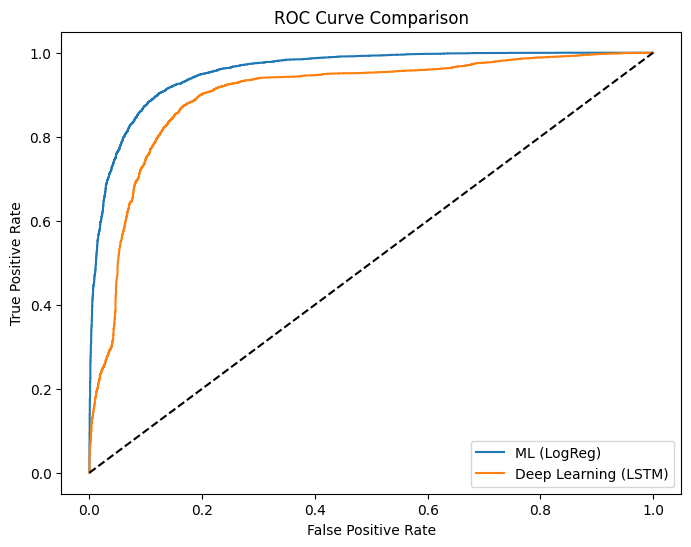

In [12]:
fpr_ml, tpr_ml, _ = roc_curve(y_test, y_prob_ml)
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_prob_dl)

plt.figure(figsize=(8,6))
plt.plot(fpr_ml, tpr_ml, label="ML (LogReg)")
plt.plot(fpr_dl, tpr_dl, label="Deep Learning (LSTM)")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


🔗 Integrating Topic Modeling with Sentiment Analysis

📌 Topic-wise Sentiment Scores:
   Topic  Avg_Sentiment
0      0       0.655834
1      1       0.330580
2      2       0.525431
3      3       0.368502
4      4       0.567918

📌 Topic-wise Sentiment Scores:
   Topic  Avg_Sentiment
0      0       0.655834
1      1       0.330580
2      2       0.525431
3      3       0.368502
4      4       0.567918


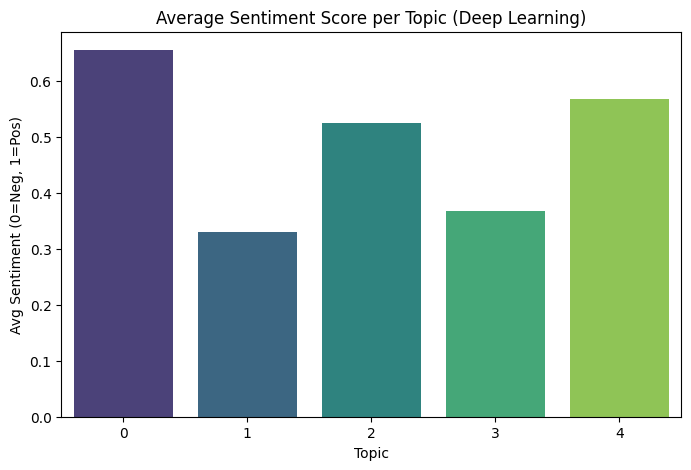

✅ Sentiment integrated with Topic Modeling


In [13]:
# ============================================
# 6. Integration: Topic Modeling + Sentiment
# ============================================

print("\n🔗 Integrating Topic Modeling with Sentiment Analysis")

# Imports (safe to re-import)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Fallbacks: load models/vectorizers if variables not in memory (e.g., after kernel restart)
try:
    lda
except NameError:
    lda = joblib.load("models/lda_model.pkl")

try:
    count_vectorizer
except NameError:
    count_vectorizer = joblib.load("models/count_vectorizer.pkl")

try:
    model
except NameError:
    model = load_model("models/sentiment_lstm.h5")

try:
    tokenizer
except NameError:
    tokenizer = joblib.load("models/sentiment_tokenizer.pkl")

# Get dominant topic per document using LDA (sklearn)
X_count = count_vectorizer.transform(merged_df["clean_text"])  # reuse fitted vectorizer
lda_doc_topic = lda.transform(X_count)
merged_df["dominant_topic"] = lda_doc_topic.argmax(axis=1)

# Use Deep Learning sentiment (best performing) for integration — batch for speed
texts = merged_df["clean_text"].tolist()
seqs = tokenizer.texts_to_sequences(texts)
max_len = 200  # keep consistent with training
X_pad_all = pad_sequences(seqs, maxlen=max_len, padding="post")

# Predict probabilities in batch
sent_probs = model.predict(X_pad_all, verbose=0).flatten()

merged_df["sentiment_score"] = sent_probs
merged_df["sentiment_label"] = (merged_df["sentiment_score"] >= 0.5).map({True: "positive", False: "negative"})

# Topic-wise Sentiment Aggregation
topic_sentiment_summary = merged_df.groupby("dominant_topic")["sentiment_score"].mean().reset_index()
topic_sentiment_summary.columns = ["Topic", "Avg_Sentiment"]

print("\n📌 Topic-wise Sentiment Scores:")
print(topic_sentiment_summary)

# Visualization
plt.figure(figsize=(8,5))
sns.barplot(x="Topic", y="Avg_Sentiment", data=topic_sentiment_summary, palette="viridis")
plt.title("Average Sentiment Score per Topic (Deep Learning)")
plt.ylabel("Avg Sentiment (0=Neg, 1=Pos)")
plt.show()

print("✅ Sentiment integrated with Topic Modeling")

In [14]:
# ============================================
# 7. Week 5: Insights Generation & Summarization
# ============================================

from transformers import pipeline
from transformers.utils import is_torch_available

print("\n📝 Week 5: Insights Generation & Summarization")

# -------------------------------------------------
# Extractive Summarization per Topic
# -------------------------------------------------

def extractive_summary(texts, num_sentences=3):
    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(texts)
    kmeans = KMeans(n_clusters=1, random_state=42).fit(X)
    avg = np.argsort(np.linalg.norm(X - kmeans.cluster_centers_, axis=1))[:num_sentences]
    return [texts[i] for i in avg]

topic_summaries_extractive = {}
for topic_id in merged_df["dominant_topic"].unique():
    topic_docs = merged_df[merged_df["dominant_topic"] == topic_id]["clean_text"].tolist()
    if len(topic_docs) > 5:
        summary = extractive_summary(topic_docs[:100], num_sentences=3)  # sample first 100 docs
        topic_summaries_extractive[topic_id] = summary

print("\n📌 Extractive Summaries by Topic:")
for t, sents in topic_summaries_extractive.items():
    print(f"\nTopic {t}:")
    for s in sents:
        print("-", s)

# -------------------------------------------------
# Abstractive Summarization (Transformer-based)
# -------------------------------------------------

use_abstractive = False
summarizer = None
if is_torch_available():
    try:
        summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=-1)
        use_abstractive = True
    except Exception as e:
        print("⚠️ Abstractive summarizer unavailable, falling back to extractive only:", str(e))
else:
    print("ℹ️ PyTorch not available; skipping abstractive summarization and using extractive only.")

# Build abstractive summaries only if supported

topic_summaries_abstractive = {}
if use_abstractive and summarizer is not None:
    for topic_id in merged_df["dominant_topic"].unique():
        topic_docs = merged_df[merged_df["dominant_topic"] == topic_id]["clean_text"].tolist()
        if len(topic_docs) > 5:
            # Limit the input length to avoid overflow (BART max ~1024 tokens)
            combined_text = " ".join(topic_docs[:50])  # fewer docs to stay within limits
            try:
                summary = summarizer(combined_text, max_length=100, min_length=30, do_sample=False)
                topic_summaries_abstractive[topic_id] = summary[0]["summary_text"]
            except Exception as e:
                # Fallback to extractive when a topic fails
                topic_summaries_abstractive[topic_id] = " ".join(extractive_summary(topic_docs[:50], num_sentences=3))
                print(f"⚠️ Abstractive failed for Topic {topic_id}; used extractive fallback. {e}")
else:
    # Populate with extractive summaries as strings for uniform downstream use
    for topic_id, sents in topic_summaries_extractive.items():
        topic_summaries_abstractive[topic_id] = " ".join(sents)

print("\n📌 Abstractive Summaries by Topic:")
for t, summ in topic_summaries_abstractive.items():
    print(f"\nTopic {t}: {summ}")

# -------------------------------------------------
# Insights Generation
# -------------------------------------------------
print("\n📊 Insights per Topic:")
insights = []
for topic_id in merged_df["dominant_topic"].unique():
    avg_sent = merged_df[merged_df["dominant_topic"] == topic_id]["sentiment_score"].mean()
    label = "Positive" if avg_sent >= 0.5 else "Negative"
    abstr_summary = topic_summaries_abstractive.get(topic_id, "No summary available")
    insights.append({"topic": topic_id, "avg_sentiment": avg_sent, "sentiment_label": label, "summary": abstr_summary})

insights_df = pd.DataFrame(insights)
print(insights_df)

# Save insights
insights_df.to_csv("topic_insights.csv", index=False)
print("💾 Insights saved as topic_insights.csv")



📝 Week 5: Insights Generation & Summarization

📌 Extractive Summaries by Topic:

Topic 1:
- chancellor rally labour voter gordon brown issued rallying cry telling supporter stake high stay home protest vote forthcoming general election chancellor said vote expected fall may give clear fundamental choice labour investment conservative cut speaking labour spring conference gateshead mr brown claimed nh safe conservative hand said tory plan cut bn tax would cut deep public service packed audience gateshead sage centre chancellor said cut proposed shadow chancellor oliver letwin equivalent sacking every teacher gp nurse country told activist laying conservative record government said give promise labour britain never return mistake erm inflation interest rate bn lost reserve repossessed one million negative equity three million unemployed never tory boom bust central dividing line election conservative party taking britain back planning deep cut bn service labour government taking britain